# Mounting Drive

In [ ]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/crowdcounting2/data/data_preparation")
!ls

create_gt_test_set_shtech.py   get_density_map_gaussian.py
create_training_set_shtech.py  __pycache__


# Density Map Function

In [ ]:
import cv2
import math
import numpy as np

def get_density_map_gaussian(im, points):

    im_density = np.zeros_like(im, dtype=np.float64)
    h, w = im_density.shape
    if points is None:
        return im_density
    if points.shape[0] == 1:
        x1 = max(0, min(w-1, round(points[0, 0])))
        y1 = max(0, min(h-1, round(points[0, 1])))
        im_density[y1, x1] = 255
        return im_density
    for j in range(points.shape[0]):
        f_sz = 15
        sigma = 4.0
        H = np.multiply(cv2.getGaussianKernel(f_sz, sigma), (cv2.getGaussianKernel(f_sz, sigma)).T)
        x = min(w-1, max(0, abs(int(math.floor(points[j, 0])))))
        y = min(h-1, max(0, abs(int(math.floor(points[j, 1])))))
        if x >= w or y >= h:
            continue
        x1 = x - f_sz//2 + 0
        y1 = y - f_sz//2 + 0
        x2 = x + f_sz//2 + 1
        y2 = y + f_sz//2 + 1
        dfx1, dfy1, dfx2, dfy2 = 0, 0, 0, 0
        change_H = False
        if x1 < 0:
            dfx1 = abs(x1) + 0
            x1 = 0
            change_H = True
        if y1 < 0:
            dfy1 = abs(y1) + 0
            y1 = 0
            change_H = True
        if x2 > w:
            dfx2 = x2 - w
            x2 = w
            change_H = True
        if y2 > h:
            dfy2 = y2 - h
            y2 = h
            change_H = True
        x1h, y1h, x2h, y2h = 1 + dfx1, 1 + dfy1, f_sz - dfx2, f_sz - dfy2
        if change_H is True:
            H = np.multiply(cv2.getGaussianKernel(y2h-y1h+1, sigma), (cv2.getGaussianKernel(x2h-x1h+1, sigma)).T)
        im_density[y1:y2, x1:x2] += H

    return im_density

# Preprocess


In [ ]:
import os
import cv2
import csv
import numpy as np
from scipy.io import loadmat
import get_density_map_gaussian


dataset = 'B'
dataset_name = ''.join(['shanghaitech_part_', dataset])
path = ''.join(['../original/ShanghaiTech/part_', dataset, '/test_data/images/'])
gt_path = ''.join(['../original/ShanghaiTech/part_', dataset, '/test_data/ground-truth/'])
gt_path_csv = ''.join(['../original/ShanghaiTech/part_', dataset, '/test_data/ground-truth_csv/'])
if not os.path.exists(gt_path_csv):
    os.makedirs(gt_path_csv)
if dataset == 'A':
    num_images = 182
else:
    num_images = 316

for i in range(1, num_images+1):    
    if i % 10 == 0:
        print('Processing {}/{} files'.format(i, num_images), '\nwriting to {}'.format(''.join([gt_path_csv, 'IMG_', str(i), '.csv'])))
    image_info = loadmat(''.join((gt_path, 'GT_IMG_', str(i), '.mat')))['image_info']
    input_img_name = ''.join((path, 'IMG_', str(i), '.jpg'))
    im = cv2.imread(input_img_name, 0)
    annPoints =  image_info[0][0][0][0][0] - 1
    im_density = get_density_map_gaussian.get_density_map_gaussian(im, annPoints)
    with open(''.join([gt_path_csv, 'IMG_', str(i), '.csv']), 'w', newline='') as fout:
        writer = csv.writer(fout)
        writer.writerows(im_density)

Processing 10/316 files 
writing to ../original/ShanghaiTech/part_B/test_data/ground-truth_csv/IMG_10.csv
Processing 20/316 files 
writing to ../original/ShanghaiTech/part_B/test_data/ground-truth_csv/IMG_20.csv
Processing 30/316 files 
writing to ../original/ShanghaiTech/part_B/test_data/ground-truth_csv/IMG_30.csv
Processing 40/316 files 
writing to ../original/ShanghaiTech/part_B/test_data/ground-truth_csv/IMG_40.csv
Processing 50/316 files 
writing to ../original/ShanghaiTech/part_B/test_data/ground-truth_csv/IMG_50.csv
Processing 60/316 files 
writing to ../original/ShanghaiTech/part_B/test_data/ground-truth_csv/IMG_60.csv
Processing 70/316 files 
writing to ../original/ShanghaiTech/part_B/test_data/ground-truth_csv/IMG_70.csv
Processing 80/316 files 
writing to ../original/ShanghaiTech/part_B/test_data/ground-truth_csv/IMG_80.csv
Processing 90/316 files 
writing to ../original/ShanghaiTech/part_B/test_data/ground-truth_csv/IMG_90.csv
Processing 100/316 files 
writing to ../origin

In [ ]:
import os
import csv
import cv2
import math
import random
import numpy as np
from scipy.io import loadmat
import get_density_map_gaussian


seed = 95461354
random.seed(seed)
N = 9
dataset = 'B'
dataset_name = ''.join(['shanghaitech_part_', dataset, '_patches_', str(N)])
path = ''.join(['../original/ShanghaiTech/part_', dataset, '/train_data/images/'])
output_path = '../formatted_trainval/'

train_path_img = ''.join((output_path, dataset_name, '/train/'))
train_path_den = ''.join((output_path, dataset_name, '/train_den/'))
val_path_img = ''.join((output_path, dataset_name, '/val/'))
val_path_den = ''.join((output_path, dataset_name, '/val_den/'))

gt_path = ''.join(['../original/ShanghaiTech/part_', dataset, '/train_data/ground-truth/'])

for i in [output_path, train_path_img, train_path_den, val_path_img, val_path_den]:
    if not os.path.exists(i):
        os.makedirs(i)

if dataset == 'A':
    num_images = 300
else:
    num_images = 400

num_val = math.ceil(num_images*0.1)
indices = list(range(1, num_images+1))
random.shuffle(indices)

for idx in range(1, num_images+1):
    i = indices[idx-1]
    if idx % 10 == 0:
        print('Processing {}/{} files'.format(idx, num_images))
    image_info = loadmat(''.join((gt_path, 'GT_IMG_', str(i), '.mat')))['image_info']
    input_img_name = ''.join((path, 'IMG_',str(i), '.jpg'))
    im = cv2.imread(input_img_name, 0)
    h, w = im.shape
    wn2, hn2 = w / 8, h / 8
    wn2, hn2 = int(wn2 / 8) * 8, int(hn2 / 8) * 8
    annPoints =  image_info[0][0][0][0][0] - 1
    if w <= wn2 * 2:
        im = cv2.resize(im, [h, wn2*2+1], interpolation=cv2.INTER_LANCZOS4)
        annPoints[:, 0] = annPoints[:, 0] * 2 * wn2 / w
    if h <= hn2 * 2:
        im = cv2.resize(im, [hn2*2+1, w], interpolation=cv2.INTER_LANCZOS4)
        annPoints[:, 1] = annPoints[:,1] * 2 * hn2 / h
    h, w = im.shape
    a_w, b_w = wn2 + 1, w - wn2
    a_h, b_h = hn2 + 1, h - hn2

    im_density = get_density_map_gaussian.get_density_map_gaussian(im, annPoints)
    for j in range(1, N+1):

        x = math.floor((b_w - a_w) * random.random() + a_w)
        y = math.floor((b_h - a_h) * random.random() + a_h)
        x1, y1 = x - wn2, y - hn2
        x2, y2 = x + wn2 - 1, y + hn2 - 1
        im_sampled = im[y1-1:y2, x1-1:x2]
        im_density_sampled = im_density[y1-1:y2, x1-1:x2]
        annPoints_sampled = annPoints[
            list(
                set(np.where(np.squeeze(annPoints[:,0]) > x1)[0].tolist()) &
                set(np.where(np.squeeze(annPoints[:,0]) < x2)[0].tolist()) &
                set(np.where(np.squeeze(annPoints[:,1]) > y1)[0].tolist()) &
                set(np.where(np.squeeze(annPoints[:,1]) < y2)[0].tolist())
            )
        ]

        annPoints_sampled[:, 0] = annPoints_sampled[:, 0] - x1
        annPoints_sampled[:, 1] = annPoints_sampled[:, 1] - y1
        img_idx = ''.join((str(i), '_',str(j)))

        if idx < num_val:
            cv2.imwrite(''.join([val_path_img, img_idx, '.jpg']), im_sampled)
            with open(''.join([val_path_den, img_idx, '.csv']), 'w', newline='') as fout:
                writer = csv.writer(fout)
                writer.writerows(im_density_sampled)
        else:
            cv2.imwrite(''.join([train_path_img, img_idx, '.jpg']), im_sampled)
            with open(''.join([train_path_den, img_idx, '.csv']), 'w', newline='') as fout:
                writer = csv.writer(fout)
                writer.writerows(im_density_sampled)

Processing 10/400 files
Processing 20/400 files
Processing 30/400 files
Processing 40/400 files
Processing 50/400 files
Processing 60/400 files
Processing 70/400 files
Processing 80/400 files
Processing 90/400 files
Processing 100/400 files
Processing 110/400 files
Processing 120/400 files
Processing 130/400 files
Processing 140/400 files
Processing 150/400 files
Processing 160/400 files
Processing 170/400 files
Processing 180/400 files
Processing 190/400 files
Processing 200/400 files
Processing 210/400 files
Processing 220/400 files
Processing 230/400 files
Processing 240/400 files
Processing 250/400 files
Processing 260/400 files
Processing 270/400 files
Processing 280/400 files
Processing 290/400 files
Processing 300/400 files
Processing 310/400 files
Processing 320/400 files
Processing 330/400 files
Processing 340/400 files
Processing 350/400 files
Processing 360/400 files
Processing 370/400 files
Processing 380/400 files
Processing 390/400 files
Processing 400/400 files


# Training

In [ ]:
import os
os.chdir("/content/drive/My Drive/crowdcounting2/")
!ls

crowdcounting.ipynb  data  weights


In [ ]:
import os
import cv2
import numpy as np
from keras import backend as K
from sklearn.utils import shuffle


def gen_imgPaths_and_labelPaths(dataset="B"):
    train_path = './data/formatted_trainval/shanghaitech_part_' + dataset + '_patches_9/train/'
    train_den_path = './data/formatted_trainval/shanghaitech_part_' + dataset + '_patches_9/train_den/'
    val_path = './data/formatted_trainval/shanghaitech_part_' + dataset + '_patches_9/val/'
    val_den_path = './data/formatted_trainval/shanghaitech_part_' + dataset + '_patches_9/val_den/'
    img_path = './data/original/ShanghaiTech/part_' + dataset + '/test_data/images/'
    den_path = './data/original/ShanghaiTech/part_' + dataset + '/test_data/ground-truth_csv/'
    print(img_path)
    train_paths = sorted([train_path + p for p in os.listdir(train_path)], key=lambda x: float(x[:-len('.jpg')].split('/')[-1].replace('_', '.')))
    train_labels = sorted([train_den_path + p for p in os.listdir(train_den_path)], key=lambda x: float(x[:-len('.jpg')].split('/')[-1].replace('_', '.')))
    validation_paths = sorted([val_path + p for p in os.listdir(val_path)], key=lambda x: float(x[:-len('.jpg')].split('/')[-1].replace('_', '.')))
    validation_labels = sorted([val_den_path + p for p in os.listdir(val_den_path)], key=lambda x: float(x[:-len('.jpg')].split('/')[-1].replace('_', '.')))
    test_paths = sorted([img_path + p for p in os.listdir(img_path)], key=lambda x: int(x[:-len('.jpg')].split('/')[-1].split('_')[1]))
    test_labels = sorted([den_path + p for p in os.listdir(den_path)], key=lambda x: int(x[:-len('.jpg')].split('/')[-1].split('_')[1]))

    return train_paths, train_labels, validation_paths, validation_labels, test_paths, test_labels


def generate_generator(img_paths, label_paths, batch_size=32, is_shuffle=False, img_flip=0):
    flag_continue = 0
    idx_total = 0
    img_paths = np.squeeze(img_paths).tolist() if isinstance(img_paths, np.ndarray) else img_paths
    label_paths = np.squeeze(label_paths).tolist() if isinstance(label_paths, np.ndarray) else label_paths
    if is_shuffle:
        paths_shuffled = shuffle(np.hstack([np.asarray(img_paths).reshape(-1, 1), np.asarray(label_paths).reshape(-1, 1)]))
        img_paths, label_paths = np.squeeze(paths_shuffled[:, 0]).tolist(), np.squeeze(paths_shuffled[:, 1]).tolist()
    data_len = len(label_paths)
    while True:
        if not flag_continue:
            x = []
            y = []
            inner_iter_num = batch_size
        else:
            idx_total = 0
            inner_iter_num = batch_size - data_len % batch_size
        for _ in range(inner_iter_num):
            if idx_total >= data_len:
                flag_continue = 1
                break
            else:
                flag_continue = 0
            img = (cv2.imread(img_paths[idx_total], 0) - 127.5) / 128
            density_map = np.loadtxt(label_paths[idx_total], delimiter=',')
            stride = 4
            density_map_quarter = np.zeros((np.asarray(density_map.shape).astype(int)//stride).tolist())
            for r in range(density_map_quarter.shape[0]):
                for c in range(density_map_quarter.shape[1]):
                    density_map_quarter[r, c] = np.sum(density_map[r*stride:(r+1)*stride, c*stride:(c+1)*stride])
            x.append(img.reshape(*img.shape, 1))
            y.append(density_map_quarter.reshape(*density_map_quarter.shape, 1))
            if img_flip:
                pass
            idx_total += 1
        if not flag_continue:
            x, y = np.asarray(x), np.asarray(y)
            yield x, y


def monitor_mae(labels, preds):
    return K.sum(K.abs(labels - preds)) / 1


def monitor_mse(labels, preds):
    return K.sum(K.square(labels - preds)) / 1

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Concatenate, Input
from keras.models import Model


def MCNN_body_branch(input_flow, flow_mode='large'):
    if flow_mode == 'large':
        filter_num_initial, conv_len_initial, maxpooling_size = 16, 9, (2, 2)
    elif flow_mode == 'medium':
        filter_num_initial, conv_len_initial, maxpooling_size = 20, 7, (2, 2)
    elif flow_mode == 'small':
        filter_num_initial, conv_len_initial, maxpooling_size = 24, 5, (2, 2)
    else:
        print('Only small/medium/large modes.')
        return None
    x = Conv2D(filter_num_initial, (conv_len_initial, conv_len_initial), padding='same', activation='relu')(input_flow)
    x = MaxPooling2D(pool_size=maxpooling_size)(x)
    x = (x)
    x = Conv2D(filter_num_initial*2, (conv_len_initial-2, conv_len_initial-2), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=maxpooling_size)(x)
    x = Conv2D(filter_num_initial, (conv_len_initial-2, conv_len_initial-2), padding='same', activation='relu')(x)
    x = Conv2D(filter_num_initial//2, (conv_len_initial-2, conv_len_initial-2), padding='same', activation='relu')(x)
    return x


def MCNN(weights=None, input_shape=(None, None, 1)):
    input_flow = Input(shape=input_shape)
    branches = []
    for flow_mode in ['large', 'medium', 'small']:
        branches.append(MCNN_body_branch(input_flow, flow_mode=flow_mode))
    merged_feature_maps = Concatenate(axis=3)(branches)
    density_map = Conv2D(1, (1, 1), padding='same')(merged_feature_maps)

    model = Model(inputs=input_flow, outputs=density_map)
    
    return model

In [ ]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, Concatenate, Input
from keras.models import load_model, load_model, Model
from keras.callbacks import ModelCheckpoint
#from MCNN import MCNN
#from utils import generate_generator, gen_imgPaths_and_labelPaths, monitor_mae, monitor_mse

# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%matplotlib inline
dataset = "B"

In [ ]:
# Data Import
train_paths, train_labels, validation_paths, validation_labels, test_paths, test_labels = gen_imgPaths_and_labelPaths(dataset)
for i in ['train_paths', 'train_labels', 'validation_paths', 'validation_labels', 'test_paths', 'test_labels']:
    print('len({}) ='.format(i), len(eval(i)))

./data/original/ShanghaiTech/part_B/test_data/images/
len(train_paths) = 3249
len(train_labels) = 3249
len(validation_paths) = 351
len(validation_labels) = 351
len(test_paths) = 316
len(test_labels) = 316


In [ ]:
# # Model
batch_size_train = 9
epochs_per_iteration = 1
batch_size_validation = 9  # len(validation_labels) // 4
batch_size_test = 1
train_generator = generate_generator(train_paths, train_labels, batch_size=len(train_paths))
validation_generator = generate_generator(validation_paths, validation_labels, batch_size=len(validation_paths))
test_generator = generate_generator(test_paths, test_labels, batch_size=len(test_paths))
train_img, train_labels = train_generator.__next__()
print('Train data reading is done.')
validation_img, validation_labels = validation_generator.__next__()
print('Validation data reading is done.')
test_img, test_labels = test_generator.__next__()
print('Test data reading is done.')
np.save('./data/train_img.npy', train_img)
np.save('./data/train_labels.npy', train_labels)
np.save('./data/validation_img.npy', validation_img)
np.save('./data/validation_labels.npy', validation_labels)
np.save('./data/test_img.npy', test_img)
np.save('./data/test_labels.npy', test_labels)


In [ ]:
# Read all data into memory
import numpy as np
train_img, train_labels, validation_img, validation_labels, test_img, test_labels = (
    np.load('./data/train_img.npy'), np.load('./data/train_labels.npy'), np.load('./data/validation_img.npy'),
    np.load('./data/validation_labels.npy'), np.load('./data/test_img.npy'), np.load('./data/test_labels.npy')
)


In [ ]:
weights_dir = 'weights'
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

checkpointer_best_val = ModelCheckpoint(
    filepath=os.path.join(weights_dir, 'mcnn_'+dataset+'_val.hdf5'),
    monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)
checkpointer_best_train = ModelCheckpoint(
    filepath=os.path.join(weights_dir, 'mcnn_'+dataset+'_train.hdf5'),
    monitor='loss', verbose=1, save_best_only=True, mode='min'
)
model = MCNN()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[monitor_mae, monitor_mse])
# model = load_model('./weights/mcnn_B_val.hdf5', custom_objects={'monitor_mae': monitor_mae, 'monitor_mse': monitor_mse})
print('Training ...')
# history = model.fit_generator(
#     train_generator, steps_per_epoch=np.ceil(len(train_paths)/batch_size_train/epochs_per_iteration),
#     epochs=epochs_per_iteration*200,
#     validation_data=validation_generator, validation_steps=len(validation_labels)/batch_size_validation//2,
#     verbose=1, callbacks=[checkpointer_best]
# )
history = model.fit(
    x=train_img, y=train_labels, batch_size=1, epochs=70,
    validation_data=(validation_img, validation_labels),
    callbacks=[checkpointer_best_val, checkpointer_best_train]
)

Training ...
Train on 3249 samples, validate on 351 samples
Epoch 1/70
3249/3249 [==============================] - 30s 9ms/step - loss: 2.4158e-04 - monitor_mae: 12.4353 - monitor_mse: 0.7421 - val_loss: 1.3389e-04 - val_monitor_mae: 6.4968 - val_monitor_mse: 0.4113

Epoch 00001: val_loss improved from inf to 0.00013, saving model to weights/mcnn_B_val.hdf5

Epoch 00001: loss improved from inf to 0.00024, saving model to weights/mcnn_B_train.hdf5
Epoch 2/70
3249/3249 [==============================] - 29s 9ms/step - loss: 2.0864e-04 - monitor_mae: 11.5741 - monitor_mse: 0.6409 - val_loss: 1.3684e-04 - val_monitor_mae: 9.0009 - val_monitor_mse: 0.4204

Epoch 00002: val_loss did not improve from 0.00013

Epoch 00002: loss improved from 0.00024 to 0.00021, saving model to weights/mcnn_B_train.hdf5
Epoch 3/70
3249/3249 [==============================] - 29s 9ms/step - loss: 2.0083e-04 - monitor_mae: 10.9997 - monitor_mse: 0.6170 - val_loss: 1.2629e-04 - val_monitor_mae: 7.6686 - val_monit

In [ ]:
model.save()

# Testing


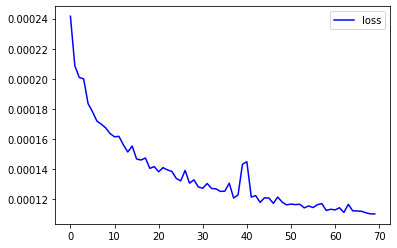

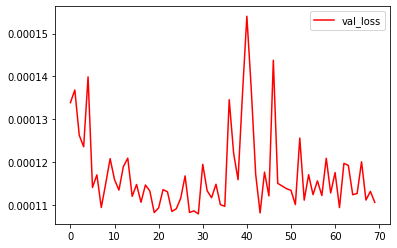

In [ ]:
val_loss, loss = history.history['val_loss'], history.history['loss']
loss = np.asarray(loss)
# loss[loss > 0.0002] = 0.0002
plt.plot(loss, 'b')
plt.legend(['loss'])
plt.show()
plt.plot(val_loss, 'r')
plt.legend(['val_loss'])
plt.show()

In [ ]:
import os
os.chdir("/content/drive/My Drive/crowdcounting2/")
!ls

'crowd counting 2 .ipynb'   crowdcounting.ipynb   data	 weights


In [ ]:
from keras import models
model = models.load_model('./weights/mcnn_B_val.hdf5', custom_objects={'monitor_mae': monitor_mae, 'monitor_mse': monitor_mse})
ae = []
se = []
num_test = 20
for i in range(test_img.shape[0])[:num_test]:
    inputs = np.reshape(test_img[i], [1, *test_img[i].shape[:2], 1])
    outputs = np.squeeze(model.predict(inputs))
#     outputs[outputs < np.mean(outputs)] = 0
    density_map = np.squeeze(test_labels[i])
    count_label = np.sum(density_map)
    count_prediction = np.sum(outputs)
    fg, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 5))
    plt.suptitle(' '.join([
        'count_label:', str(round(count_label, 3)),
        'count_prediction:', str(round(count_prediction, 3))
    ]))
    ax0.imshow(np.squeeze(inputs), cmap='gray')
    ax1.imshow(density_map * (255 / (np.max(density_map) - np.min(density_map))), cmap='gray')
    ax2.imshow(outputs * (255 / (np.max(outputs) - np.min(outputs))), cmap='gray')
    plt.show()
    ae.append(abs(count_label - count_prediction))
    se.append((count_label - count_prediction) ** 2)
mae = np.mean(ae)
mse = np.mean(se)
print('mae:', mae, 'mse:', mse)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
score = model.evaluate(test_img, test_labels, verbose= 0)
print('Test loss:',score[0])
print('Test accuracy:',score[1])

Test loss: 0.0002196222747074841
Test accuracy: 4392.058071474486
